In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import utils as ut

In [17]:
def make_df(fnames, 
    old_frame=None, 
    reward_ahead=10, 
    timestep_gap=1, 
    prev_act_window=3, 
    jump_limit=100,
    ):

    '''
    Takes a file and turns it into a trajectory dataframe.
    Can add to old data.
    Inputs:
                old_frame: old df
             reward_ahead: how many steps ahead to sum reward, for each table entry
             timestep_gap: how data are sampled (e.g. =5 means only every fifth datapoint is kept)
          prev_act_window: how many steps to look back to make sure all actions were 'on' or 'off'
               jump_limit: data are processed to remove faulty points where worm loc has jumped really far.
                           This is the maximum jump distance allowed before points are tossed.
                     disc: discretization of angles

    Output:
        dataframe object with keys:
            't', 'obs_b', 'obs_h', 'prev_actions', 'next_obs_b', 'next_obs_h', 'reward', 'loc'
    '''
    def add_ind_to_df(traj,df,i, reward_ahead, prev_act_window):
        # Assumes data for angle observations go from -1 to 1. (not sure why)
        ANG_BOUND = 180
        return df.append({
            't'           : traj['t'][i],
            'obs_b'       : int(traj['obs'][i][0]*ANG_BOUND),
            'obs_h'       : int(traj['obs'][i][1]*ANG_BOUND),
            'prev_actions': sum(traj['action'][i-prev_act_window:i]), # Note does not include current action
            'next_obs_b'  : int(traj['obs'][i+1][0]*ANG_BOUND),
            'next_obs_h'  : int(traj['obs'][i+1][1]*ANG_BOUND),
            'reward'      : sum(traj['reward'][i:i+reward_ahead]),
            'loc'         : traj['loc'][i],
        }, ignore_index=True)

    if old_frame is None:
        df = pd.DataFrame(columns = ['t', 
            'obs_b', 'obs_h', 'prev_actions', 
            'next_obs_b', 'next_obs_h', 'reward', 'loc'])
    else:
        df = old_frame

    # For every file, loop through and remove problem points.
    for fname in fnames:
        newf = True
        with open(fname, 'rb') as f:
            traj = pickle.load(f)

        for i in np.arange(prev_act_window,len(traj['t'])-reward_ahead,timestep_gap):
            # For every timestep, check if the jump is reasonable and add to dataframe.
            if newf:
                if sum(traj['loc'][i])!=0:
                    df = add_ind_to_df(traj,df,i,reward_ahead,prev_act_window)
                    newf = False
            elif np.sqrt(np.sum(np.square(df['loc'].iloc[-1]-traj['loc'][i]))) < jump_limit:
                df = add_ind_to_df(traj,df,i,reward_ahead,prev_act_window)

    return df

In [2]:
fnames=[
    # First worm
    'Data/traj12-11-2020_19-04-41.pkl', #none
    'Data/traj12-11-2020_19-14-38.pkl', #none
    'Data/traj12-11-2020_19-24-30.pkl', #xlim 800
    'Data/traj12-11-2020_19-35-31.pkl', #none # Seems like an especially bad dataset. Actually ruined all the others

    # Second worm
    'Data/traj12-11-2020_19-55-19.pkl', #none
    'Data/traj12-11-2020_20-05-11.pkl', #none
    'Data/traj12-11-2020_20-15-17.pkl', #none
    'Data/traj12-11-2020_20-25-06.pkl', #xlim 1430

    # Third worm
    'Data/traj30-10-2020_18-14-00.pkl', #none
    'Data/traj30-10-2020_18-34-10.pkl', #none

    # Fourth worm
    'Data/traj02-11-2020_15-53-56.pkl', #none 
    'Data/traj02-11-2020_16-14-45.pkl', #none 

    # Fifth worm
    'Data/traj03-11-2020_14-46-45.pkl', #none
    'Data/traj03-11-2020_15-08-07.pkl', #none
]

traj_df = ut.make_df(fnames, 
    old_frame=None, 
    reward_ahead=10, 
    timestep_gap=1, 
    prev_act_window=3, 
    jump_limit=100,
    )

KeyboardInterrupt: 

In [3]:
#traj_df.to_pickle('./nogap_traj_df.pkl') 
# Hyperparameters:
#     old_frame=None, 
#     reward_ahead=10, 
#     timestep_gap=1, 
#     prev_act_window=3, 
#     jump_limit=100,

with open('./nogap_traj_df.pkl','rb') as f:
    traj = pickle.load(f)

In [2]:
#traj_df.to_pickle('./all_traj_df.pkl') 
# Hyperparameters:
#     old_frame=None, 
#     reward_ahead=10, 
#     timestep_gap=5, 
#     prev_act_window=3, 
#     jump_limit=100,

with open('./all_traj_df.pkl','rb') as f:
    traj = pickle.load(f)

In [40]:
r_sts,b_sts,h_sts, counts = make_stat_mats(traj_df)

In [70]:
locs = np.zeros((len(traj_df),2))
for i in range(locs.shape[0]):
    locs[i,:] = traj_df['loc'][i]

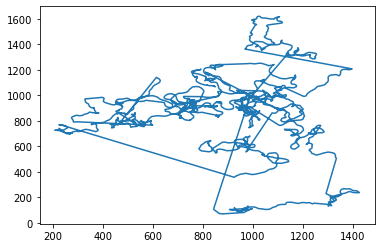

In [82]:
plt.plot(locs[:,0],locs[:,1])

In [108]:
def wrap_correct(arr,ref=0,buffer=180):
    # Takes angles and translates them to +/-buffer around ref.
    # For things like std, use large buffer so it doesn't change
    # If both arrays, send each element through this function.
    if hasattr(arr,"__len__"):
        if hasattr(ref,"__len__"):
            for i in range(len(arr)):
                arr[i] = wrap_correct(arr[i],ref=ref[i])
        # If only arr is an array
        else:
            arr[arr<ref-buffer]+=buffer*2
            arr[arr>=ref+buffer]-=buffer*2
            if len(arr[arr<ref-buffer])>0 or len(arr[arr>=ref+buffer])>0:
                arr = wrap_correct(arr,ref=ref)
    else:
        if arr<ref-buffer:
            arr+=buffer*2
            if arr<ref-buffer:
                arr = wrap_correct(arr,ref=ref)
        elif arr>=ref+buffer:
            arr-=buffer*2
            if arr>=ref+buffer:
                arr = wrap_correct(arr,ref=ref)
    return arr

In [29]:
def make_stat_mats(df, cut_reversals=True):
    # This version should have an option to check HT switches so I can test.
    # Inner func does most of the work querying for each obs.
    # cut_reversals is True if body angle switches happen. Note that it does cut both incorrect
    #   switches and correct ones.
    # Returns everything at once: 
    #   r_mat[12,12,2], b_mat[12,12,2], h_mat[12,12,2], counts[12,12].

    def get_stats_angs(df, obs, cut_reversals=True):
        # Gets mean and var of df values that match obs, centered on obs
        # Remove points where HT orientation switched
        # Returns r_stats, b_stats, h_stats, count. The first three are tuples [mu,var].

        if cut_reversals:
            backwards = obs[0]-180
            if backwards < -180:
                backwards += 360
        else:
            backwards = 1e5

        df_d = dict(zip(df.columns,range(len(df.columns))))
        series = df.query('obs_b=='+str(obs[0])+'& obs_h=='+str(obs[1])+
            '& next_obs_b!='+str(backwards)).copy()
        series.iloc[:,df_d['next_obs_b']] = wrap_correct(series['next_obs_b'].to_numpy(),ref=series['obs_b'].to_numpy())
        series.iloc[:,df_d['next_obs_h']] = wrap_correct(series['next_obs_h'].to_numpy(),ref=series['obs_h'].to_numpy())

        # Handles case for one sample (initialize)
        r_sts,b_sts,h_sts,count = [np.nan,np.nan],[np.nan,np.nan],[np.nan,np.nan],0
        if series.size > 0:    
            r_sts[0],b_sts[0],h_sts[0] = wrap_correct(series['reward'].mean()), \
                                            wrap_correct(series['next_obs_b'].mean()), \
                                            wrap_correct(series['next_obs_h'].mean())
            if series.size > 1:
                r_sts[1],b_sts[1],h_sts[1] = series['reward'].var(), \
                                                series['next_obs_b'].var(), \
                                                series['next_obs_h'].var()
        return r_sts,b_sts,h_sts,series.size


    r_mat = np.zeros((12,12,2)) + np.nan 
    b_mat = np.zeros((12,12,2)) + np.nan 
    h_mat = np.zeros((12,12,2)) + np.nan 
    counts = np.zeros((12,12))

    for i,theta_b in enumerate(np.arange(-180,180,30)):
        for j,theta_h in enumerate(np.arange(-180,180,30)):
            r_sts,b_sts,h_sts,counts[i,j] = get_stats_angs(df,[theta_b,theta_h])
            r_mat[i,j,:] = r_sts
            b_mat[i,j,:] = b_sts
            h_mat[i,j,:] = h_sts

    return r_mat, b_mat, h_mat, counts

def wrap_correct(arr,ref=0,buffer=180):
    # Takes angles and translates them to +/-buffer around ref.
    # For things like std, use large buffer so it doesn't change
    # If both arrays, send each element through this function.
    if hasattr(arr,"__len__"):
        if hasattr(ref,"__len__"):
            for i in range(len(arr)):
                arr[i] = wrap_correct(arr[i],ref=ref[i])
        # If only arr is an array
        else:
            arr[arr<ref-buffer]+=buffer*2
            arr[arr>=ref+buffer]-=buffer*2
            if len(arr[arr<ref-buffer])>0 or len(arr[arr>=ref+buffer])>0:
                arr = wrap_correct(arr,ref=ref)
    else:
        if arr<ref-buffer:
            arr+=buffer*2
            if arr<ref-buffer:
                arr = wrap_correct(arr,ref=ref)
        elif arr>=ref+buffer:
            arr-=buffer*2
            if arr>=ref+buffer:
                arr = wrap_correct(arr,ref=ref)
    return arr

In [30]:
df = traj_df

r_sts,b_sts,h_sts,counts=make_stat_mats(df)

In [43]:
df = traj_df
obs=[150,150]
series = df.query('obs_b=='+str(obs[0])+'& obs_h=='+str(obs[1])+
    '& next_obs_b!='+str(backwards)).copy()

In [57]:
r_mat, b_mat, h_mat, counts = make_stat_mats(traj_df)

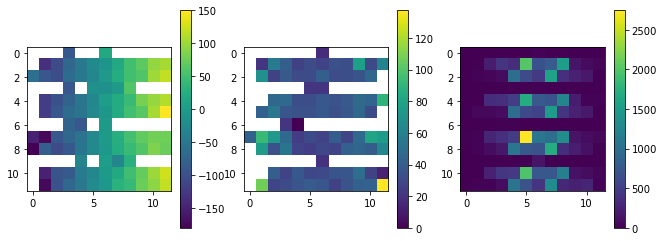

In [58]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches((11,4))
ims = ax[0].imshow(h_mat[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(h_mat[:,:,1]))
fig.colorbar(ims,ax=ax[1])
ims = ax[2].imshow(counts)
fig.colorbar(ims,ax=ax[2])

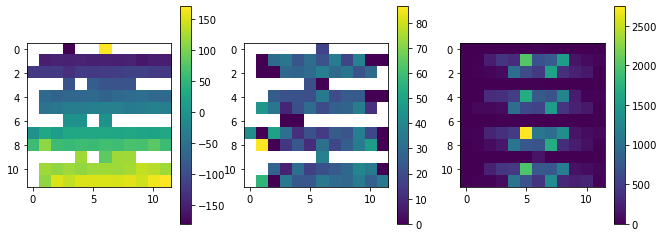

In [59]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches((11,4))
ims = ax[0].imshow(b_mat[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(b_mat[:,:,1]))
fig.colorbar(ims,ax=ax[1])
ims = ax[2].imshow(counts)
fig.colorbar(ims,ax=ax[2])

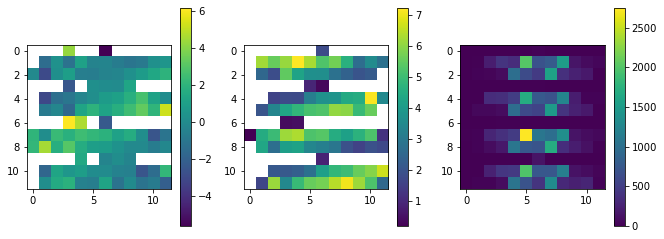

In [60]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches((11,4))
ims = ax[0].imshow(r_mat[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(r_mat[:,:,1]))
fig.colorbar(ims,ax=ax[1])
ims = ax[2].imshow(counts)
fig.colorbar(ims,ax=ax[2])

# Full utils testing

In [329]:
sm_h_new = smoothen(h_on[:,:,0], count_on, True, smooth_par=.05, iters=30)

In [38]:
df = traj
prev_act_window=3
cut_reversals=False
sm_pars = {'lambda':.03,'iters':40}

traj_on = df.query('prev_actions=='+str(prev_act_window))
traj_off = df.query('prev_actions==0')

r_on, b_on, h_on, count_on = ut.make_stat_mats(traj_on, cut_reversals=cut_reversals)
r_off, b_off, h_off, count_off = ut.make_stat_mats(traj_off, cut_reversals=cut_reversals)

all_mats = [r_on,b_on,h_on,r_off,b_off,h_off]
counts = [count_on,count_off]

for i in range(len(all_mats)):
    for j in range(2):
        if j==1 or i==0 or i==3:
            ang_par = False
        else:
            ang_par = True
        all_mats[i][:,:,j] = ut.lin_interp_mat(all_mats[i][:,:,j], ang_par)
        
        if sm_pars is not None:
            all_mats[i][:,:,j] = ut.smoothen(all_mats[i][:,:,j], 
                                             counts[i//3], ang_par, 
                                             smooth_par=sm_pars['lambda'], iters=sm_pars['iters'])

dist_dict = {
    'body_on': b_on,
    'body_off': b_off,
    'head_on': h_on,
    'head_off': h_off,
    'reward_on': r_on,
    'reward_off': r_off,
}    

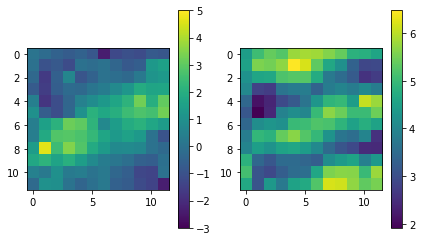

In [39]:
tmat = dist_dict['reward_on']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0],vmin=-3,vmax=5)
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

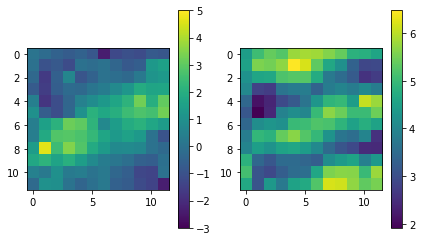

In [30]:
tmat = dist_dict['reward_on']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0],vmin=-3,vmax=5)
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

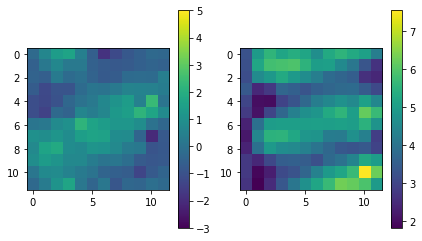

In [40]:
tmat = dist_dict['reward_off']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0],vmin=-3,vmax=5)
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

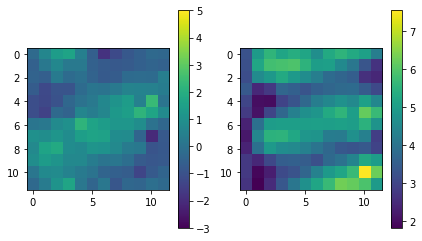

In [31]:
tmat = dist_dict['reward_off']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0],vmin=-3,vmax=5)
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

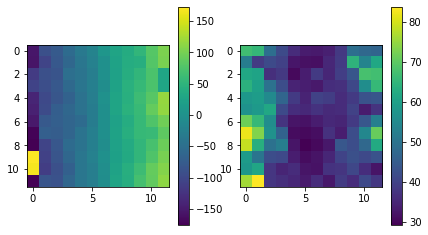

In [36]:
tmat = dist_dict['head_on']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

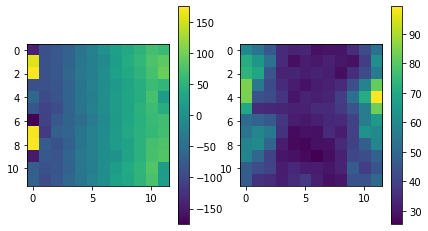

In [37]:
tmat = dist_dict['head_off']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

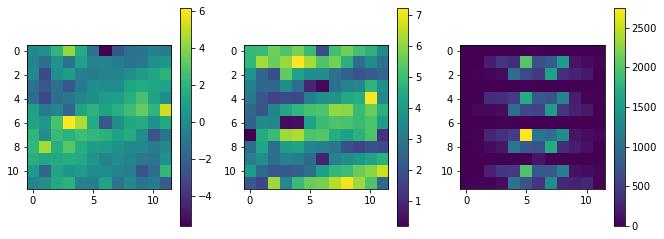

In [4]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches((11,4))
ims = ax[0].imshow(r_on[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(r_on[:,:,1]))
fig.colorbar(ims,ax=ax[1])
ims = ax[2].imshow(count_on)
fig.colorbar(ims,ax=ax[2])

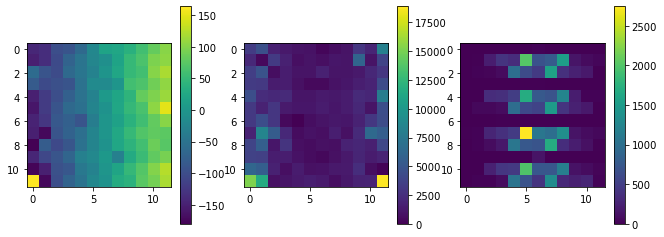

In [31]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches((11,4))
ims = ax[0].imshow(h_on[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(h_on[:,:,1])
fig.colorbar(ims,ax=ax[1])
ims = ax[2].imshow(count_on)
fig.colorbar(ims,ax=ax[2])

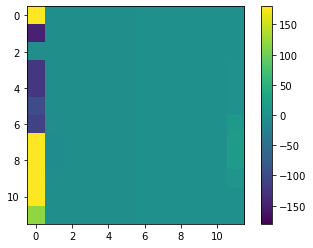

In [330]:
plt.imshow(sm_h_new-sm_h,vmin=-180,vmax=180)
plt.colorbar();

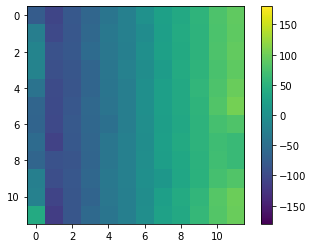

In [327]:
plt.imshow(sm_h,vmin=-180,vmax=180)
plt.colorbar();

In [196]:
def make_wraparound(mat,ang,wraparound=True):
    # Expands matrix for wraparound interpolation
    # If matrix is angle values, set ang=True.
    mat_new = np.zeros((np.array(mat.shape)+2)) + np.nan
    mat_new[1:-1,1:-1] = mat
    if ang:
        buffer=180
    else:
        buffer=None

    if wraparound:
        # diagonals
        mat_new[0,0] = wrap_correct(mat[-1,-1], ref=mat[0,0], buffer=buffer)
        mat_new[0,-1] = wrap_correct(mat[-1,0], ref=mat[0,-1], buffer=buffer)
        mat_new[-1,0] = wrap_correct(mat[0,-1], ref=mat[-1,0], buffer=buffer)
        mat_new[-1,-1] = wrap_correct(mat[0,0], ref=mat[-1,-1], buffer=buffer)
        # adjacents
        mat_new[0,1:-1] = wrap_correct(mat[-1,:], ref=mat[0,:], buffer=buffer)
        mat_new[-1,1:-1] = wrap_correct(mat[0,:], ref=mat[-1,:], buffer=buffer)
        mat_new[1:-1,0] = wrap_correct(mat[:,-1], ref=mat[:,0], buffer=buffer)
        mat_new[1:-1,-1] = wrap_correct(mat[:,0], ref=mat[:,-1], buffer=buffer)
    return mat_new

In [189]:
def wrap_correct(arr_orig,ref=0,buffer=None):
    # Takes angles and translates them to +/-buffer around ref.
    # For things like std, use large buffer so it doesn't change
    # If both arrays, send each element through this function.
    if buffer is None:
        return arr_orig
    
    if hasattr(arr_orig,"__len__"):
        arr = arr_orig.copy()
        if hasattr(ref,"__len__"):
            for i in range(len(arr)):
                arr[i] = wrap_correct(arr[i],ref=ref[i])
        # If only arr is an array
        else:
            arr[arr<ref-buffer]+=buffer*2
            arr[arr>=ref+buffer]-=buffer*2
            if len(arr[arr<ref-buffer])>0 or len(arr[arr>=ref+buffer])>0:
                arr = wrap_correct(arr,ref=ref)
    else:
        arr = arr_orig
        if arr<ref-buffer:
            arr+=buffer*2
            if arr<ref-buffer:
                arr = wrap_correct(arr,ref=ref)
        elif arr>=ref+buffer:
            arr-=buffer*2
            if arr>=ref+buffer:
                arr = wrap_correct(arr,ref=ref)
    return arr

In [328]:
def smoothen(matrix,counts,ang,smooth_par=.05,iters=30,wraparound=True,diagonals=True): 
    # matrix is in form [12,12]
    # counts is [12,12].
    # ang is bool, True if angle matrix
    # Will start with a simple linear weighting/smoothing. 
    
    # So the shapes start out right before looping 
    matrix = make_wraparound(matrix, ang, wraparound=True)
    counts = make_wraparound(counts, False, wraparound=True)
    if ang:
        buffer=180
    else:
        buffer=None
    
    for it in range(iters):
        matrix = make_wraparound(matrix[1:-1,1:-1], ang, wraparound=True)
        tempmat = np.copy(matrix) # Now tempmat and matrix are the same extended size
        rows,cols = np.array(matrix.shape)-2 

        # Loops through each matrix element and weights changes by counts
        for i in np.arange(rows)+1:
            for j in np.arange(cols)+1:
                neighs = wrap_correct(np.append(ut.get_neighbors(matrix,(i,j)), matrix[i,j]), ref=matrix[i,j], buffer=buffer)
                neigh_counts = np.append(ut.get_neighbors(counts,(i,j)), counts[i,j])
                del_sm = np.sum(np.multiply(neigh_counts, neighs))
                if diagonals:
                    # Diagonal entries (scaled by 1/sqrt(2))
                    neighs_d = wrap_correct(np.append(ut.get_diags(matrix,(i,j)), matrix[i,j]), ref=matrix[i,j], buffer=buffer)
                    neighs_counts_d = np.append(ut.get_diags(counts,(i,j)), counts[i,j])
                    del_sm_d = (np.sum(np.multiply(neighs_counts_d, neighs_d)))/np.sqrt(2)
                    Z = np.sum(neigh_counts) + np.sum(neighs_counts_d)/np.sqrt(2)
                else:
                    del_sm_d = 0
                    Z = np.sum(neigh_counts)

                tempmat[i,j] = tempmat[i,j] + smooth_par*(del_sm/Z+del_sm_d/Z - tempmat[i,j])
                
        # After tempmat is updated, set reference matrix to be the same
        # This way updates within one iteration don't get included in the same iteration
        matrix = np.copy(tempmat)
        
        if it==0:
            counts+=1
    
    return wrap_correct(matrix[1:-1,1:-1], buffer=buffer)

In [325]:
def smoothen(matrix,counts,ang,smooth_par=.05,iters=30,wraparound=True,diagonals=True): 
    # matrix is in form [12,12]
    # counts is [12,12].
    # ang is bool, True if angle matrix
    # Will start with a simple linear weighting/smoothing. 
    
    # So the shapes start out right before looping 
    matrix = make_wraparound(matrix, ang, wraparound=True)
    counts = make_wraparound(counts, False, wraparound=True)
    
    for it in range(iters):
        matrix = make_wraparound(matrix[1:-1,1:-1], ang, wraparound=True)
        tempmat = np.copy(matrix) # Now tempmat and matrix are the same extended size
        rows,cols = np.array(matrix.shape)-2 

        # Loops through each matrix element and weights changes by counts
        for i in np.arange(rows)+1:
            for j in np.arange(cols)+1:
                neighs = np.append(get_neighbors(matrix,(i,j)), matrix[i,j])
                neigh_counts = np.append(get_neighbors(counts,(i,j)), counts[i,j])
                del_sm = np.sum(np.multiply(neigh_counts, neighs))
                if diagonals:
                    # Diagonal entries (scaled by 1/sqrt(2))
                    neighs_d = np.append(get_diags(matrix,(i,j)), matrix[i,j])
                    neighs_counts_d = np.append(get_diags(counts,(i,j)), counts[i,j])
                    del_sm_d = (np.sum(np.multiply(neighs_counts_d, neighs_d)))/np.sqrt(2)
                    Z = np.sum(neigh_counts) + np.sum(neighs_counts_d)/np.sqrt(2)
                else:
                    del_sm_d = 0
                    Z = np.sum(neigh_counts)

                tempmat[i,j] = tempmat[i,j] + smooth_par*(del_sm/Z+del_sm_d/Z - tempmat[i,j])
                
        # After tempmat is updated, set reference matrix to be the same
        # This way updates within one iteration don't get included in the same iteration
        matrix = np.copy(tempmat)

        if it==0:
            counts+=1
    
    return wrap_correct(matrix[1:-1,1:-1], buffer=buffer)

def get_neighbors(mat,i):
    # Makes array of four neighbors around mat[index]
    # index is a pair
    return np.array([mat[i[0],i[1]-1], mat[i[0],i[1]+1], mat[i[0]-1,i[1]], mat[i[0]+1,i[1]]])

def get_diags(mat,i):
    return np.array([mat[i[0]-1,i[1]-1], mat[i[0]-1,i[1]+1], mat[i[0]+1,i[1]-1], mat[i[0]+1,i[1]+1]])

In [11]:
traj

,t,obs_b,obs_h,prev_actions,next_obs_b,next_obs_h,reward,loc
0,0.953,30,60,3,-150,-120,-3.616162,"[848.7272727272727, 1067.8181818181818]"
1,1.140,-150,-120,3,30,-30,-0.737374,"[848.3, 1068.0]"
2,1.312,30,-30,3,150,-60,-1.857143,"[848.25, 1068.0]"
3,1.500,150,-60,2,150,-60,1.714286,"[847.8333333333334, 1068.1666666666667]"
4,1.672,150,-60,1,150,150,-0.033333,"[848.0, 1068.125]"
...,...,...,...,...,...,...,...,...
31077,94.172,30,-90,0,30,-90,5.218882,"[824.3037974683544, 1152.73417721519]"
31078,94.375,30,-90,1,30,-120,4.565503,"[824.4230769230769, 1152.5384615384614]"
31079,94.563,30,-120,2,-30,-60,4.918896,"[824.8375, 1151.8875]"
31080,94.766,-30,-60,3,-30,-60,5.030357,"[825.1, 1151.2625]"


In [4]:
dist_dict = ut.make_dist_dict(traj, sm_pars={'lambda':.05,'iters':30}, cut_reversals=False)

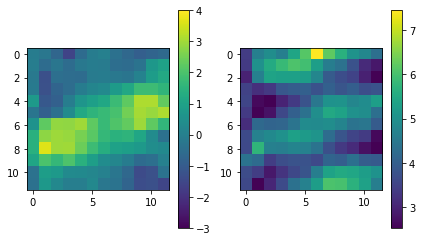

In [25]:
tmat = dist_dict['reward_on']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0],vmin=-3,vmax=4)
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

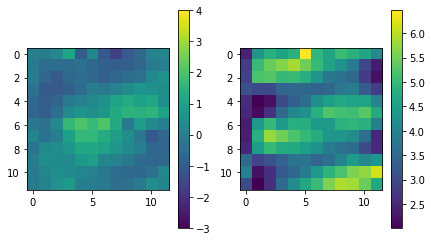

In [18]:
tmat = dist_dict['reward_off']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0],vmin=-3,vmax=4)
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

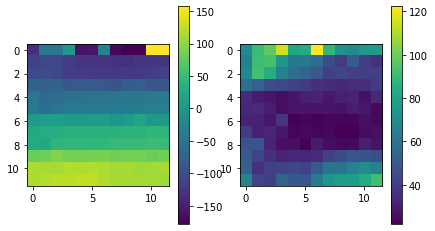

In [20]:
tmat = dist_dict['body_on']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

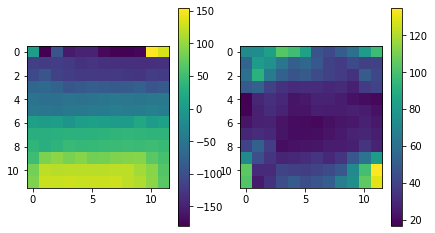

In [22]:
tmat = dist_dict['body_off']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

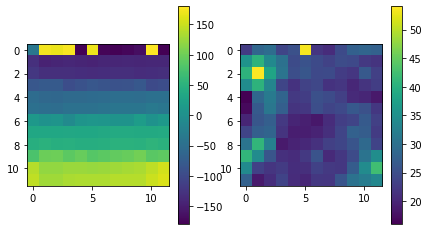

In [7]:
tmat = dist_dict['body_off']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

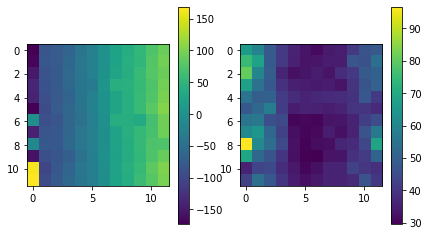

In [23]:
tmat = dist_dict['head_on']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

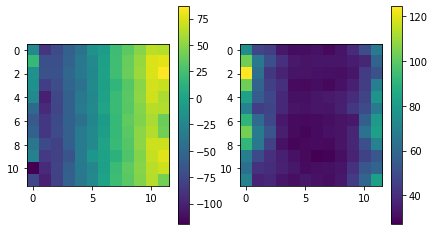

In [24]:
tmat = dist_dict['head_off']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

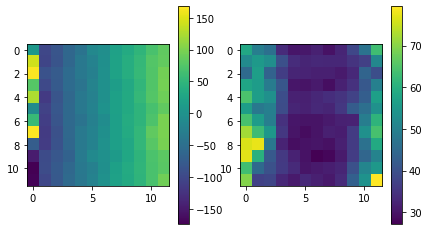

In [10]:
tmat = dist_dict['head_off']
fig,ax = plt.subplots(1,2)
fig.set_size_inches((7,4))
ims = ax[0].imshow(tmat[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(tmat[:,:,1]))
fig.colorbar(ims,ax=ax[1])

In [11]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import utils as ut

class FakeWorm(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, dist_dict, start=None, ep_len=None):
        '''
        distribution_dict must have the following:
        body_on: [12,12,2] with dimensions [body angle, head angle, mu/sig]. 
        body_off: ''
        head_on: ''
        head_off: ''
        reward_on: ''
        reward_off: ''
        '''
        super(FakeWorm, self).__init__()
        # Setting environment parameters
        self.grid_width = 12        
        self.action_space = spaces.Discrete(2) # Light off or on.
        self.observation_space = spaces.Discrete(self.grid_width**2) 
        
        # Setting initial conditions
        if start is None:
            self._state = np.random.choice(self.grid_width**2)
        else:
            self._state = self.grid2obs(start)
        self.state = self.obs2grid(self._state)
        self.state_inds = self.grid2coords(self.state)
            
        # Setting self parameters
        self.dist_dict = dist_dict
        self.ep_len = ep_len
        self.steps = 0
        self.finished = False
    

    def step(self, action):
        """Chooses action and returns a (step_type, reward, discount, observation)"""
        self.steps += 1
        # If step count reaches episode length
        if self.ep_len is not None and self.steps >= self.ep_len:
            self.finished = True
            
        # Draws new reward and state from previous state 
        if action==0:
            self.state[0] = self.get_sample('body_off', self.state_inds)
            self.state[1] = self.get_sample('head_off', self.state_inds)
            reward = self.get_sample('reward_off', self.state_inds)
        elif action==1:
            self.state[0] = self.get_sample('body_on', self.state_inds)
            self.state[1] = self.get_sample('head_on', self.state_inds)
            reward = self.get_sample('reward_on', self.state_inds)
        else:
            raise ValueError('Invalid action')
                       
        # Return obs, reward, done (boolean), info (dict)
        self._state = self.grid2obs(self.state)
        self.state_inds = self.grid2coords(self.state)
        return self._state, reward, self.finished, {}

        
    def reset(self,start=None):
        """Returns the first `TimeStep` of a new episode."""
        self.finished = False
        self.steps = 0
        # Setting initial conditions
        if start is None:
            self._state = np.random.choice(self.grid_width**2)
        else:
            self._state = self.grid2obs(start)
        self.state = self.obs2grid(self._state)
        self.state_inds = self.grid2coords(self.state)
        
        # Takes one step and returns the observation
        return self._state
    
    def render(self, mode='human', close=False):
        print('At',self.state)


    ''' Utility '''
    def get_sample(self,dkey,olds):
        # Returns a single sample from normal distribution given by statistics in dictionary[dkey], 
        # at location given by olds (index into matrix in dkey)
        mu,variance = self.dist_dict[dkey][olds[0],olds[1]]
        if 'reward' in dkey:
            return np.random.normal(mu,np.sqrt(variance))
        else:
            return ut.wrap_correct(self.myround(np.random.normal(mu,np.sqrt(variance))),buffer=180)
                       
    def myround(self, x, base=30):
        return base * round(x/base)

    ''' Conversion functions '''
    # obs is from 0 to 143.
    # grid is [-180 to 150, -180 to 150]
    # coords is [0 to 11, 0 to 11]
    def obs2grid(self,obs):
        if obs<0 or obs>143:
            raise ValueError('obs is out of range.')
        gridcoords = np.array([obs//self.grid_width, obs%self.grid_width])
        return (gridcoords*30)-180
    def grid2obs(self,gridcoords):
        if gridcoords[0]<-180 or gridcoords[0]>=180:
            if gridcoords[1]<-180 or gridcoords[0]>=180:
                raise ValueError('gridcoords are out of range.')
        tcoords = ((np.array(gridcoords)+180)/30).astype(int)
        return self.grid_width*tcoords[0] + tcoords[1]
    def grid2coords(self,gridcoords):
        if gridcoords[0]<-180 or gridcoords[0]>=180:
            if gridcoords[1]<-180 or gridcoords[0]>=180:
                raise ValueError('gridcoords are out of range.')
        coords = (np.array(gridcoords)+180)//30
        return coords
    def coords2grid(self,coords):
        #Unused
        return (np.array(coords)*30)-180
    ''' End of conversion functions '''

In [12]:
worm = FakeWorm(dist_dict)

In [13]:
for i in np.arange(12):
    print(i)
    for j in np.arange(12):
        for t in range(int(1e4)):
            sam = worm.get_sample('body_off',[i,j])
            if sam<-180 or sam>=180:
                print(i,j,sam)
                raise ValueError('Mistake')

0
1
2
3
4
5
6
7
8
9
10
11


In [15]:
worm.dist_dict['body_off'][:,:,1]

array([[ 512.79205936,  819.08325396,  878.31920658,  572.74597148,
         647.9570787 , 2863.11674918,  482.00635373,  436.25520109,
         603.7227819 ,  765.38076246,  807.19341943,  771.31889853],
       [1267.20861796, 1648.19060387, 1162.21770759,  911.91667519,
         609.75514447,  655.71998545,  605.02629375,  557.09583566,
         621.6414576 ,  599.30661195,  500.11562478,  471.09409455],
       [1648.69791752, 2921.05492222, 1459.74424967,  938.67459267,
         633.39355623,  688.08055955,  593.65655316,  601.6158933 ,
         518.88336962,  486.22049996,  712.11881408,  537.3343281 ],
       [1193.50009925, 1655.01234417, 1114.20136789,  574.5089482 ,
         467.07996394,  555.10051043,  581.35191374,  469.46843061,
         487.48362144,  411.64855982,  473.7102666 ,  527.00124981],
       [ 257.06267974,  827.7530641 , 1006.52193369,  803.30049177,
         501.82933509,  524.64788888,  639.71790581,  614.52000478,
         537.80240995,  421.54904029,  404.5

In [18]:
mu,variance = worm.dist_dict['body_off'][0,3]
variance=20000
for i in range(10):
    tmp = ut.wrap_correct(np.random.normal(mu,np.sqrt(variance)))
    print(tmp)

152.89954070600263
31.887163953357287
-130.16914068231273
154.89438273221762
27.150650279767945
46.54549283040876
174.37379741422296
46.69457898587447
-102.1658096541322
-139.1481528520599


In [ ]:
for t in range(int(1e4)):
    sam = worm.get_sample('body_off',[0,3])
        if sam<-180 or sam>=180:
            print(i,j,sam)
            raise ValueError('Mistake')